In [1]:
#import the necessary packages
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)

In [3]:
# utils
# one hot encoding
def one_hot_encoding(labels, C, sess):
    """
    Arguments:
    labels - the input matrix of shape (1, no_of_elements)
    C - the number of classes each element has to be one-hot encoded
    sess - tensorflow session
    
    Retuns:
    one_hot - one hot matrix form of input as a tensorflow tensor
    """
    labels = np.squeeze(labels)
    one_hot_tensor = tf.one_hot(labels, C, axis = 0)
    one_hot = sess.run(one_hot_tensor)
    
    return one_hot


#generate random mini batches
def generate_random_mini_batch(X_train, Y_train, mini_batch_size, seed=0):
    """
    Arguments:
    X_train - train set
    Y_train - train labels
    mini_batch_size - mini batch size(default=64)
    seed - seed used to randomize the data while generating mini batches(default = 0)
    
    Returns:
    mini_batches - a list of mini batches tuples (mini batch x, mini batch y)
    """
    
    
    m = X_train.shape[1]
    mini_batches = []
    

    np.random.seed(seed)
    
    permutation  = list(np.random.permutation(m))
    shuffled_X = X_train[:, permutation]
    shuffled_Y = Y_train[:, permutation]
    
    num_of_batches = int(m / mini_batch_size)
    for i in range(0, num_of_batches):
        mini_batch_start = i * mini_batch_size
        mini_batch_end = mini_batch_start + mini_batch_size
        mini_batch_x = shuffled_X[:, mini_batch_start : mini_batch_end]
        mini_batch_y = shuffled_Y[:, mini_batch_start : mini_batch_end]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
        
    #handling the last case
    if m != mini_batch_size * num_of_batches:
        mini_batch_start = num_of_batches * mini_batch_size
        mini_batch_end = m
        mini_batch_x = shuffled_X[:, mini_batch_start : mini_batch_end]
        mini_batch_y = shuffled_Y[:, mini_batch_start : mini_batch_end]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [4]:
#load data
def load_dataset():
    train_dataset = h5py.File('dataset/train_signs.h5', "r")
    train_dataset_x = np.array(train_dataset["train_set_x"][:])
    train_dataset_y = np.array(train_dataset["train_set_y"][:])
    
    test_dataset = h5py.File("dataset/test_signs.h5", "r")
    test_dataset_x = np.array(test_dataset["test_set_x"][:])
    test_dataset_y = np.array(test_dataset["test_set_y"][:])
    
    classes = np.array(test_dataset["list_classes"][:])
    
    train_dataset_y = train_dataset_y.reshape((1, train_dataset_y.shape[0]))
    test_dataset_y = test_dataset_y.reshape((1, test_dataset_y.shape[0]))
    classes = classes.reshape(-1)
    
    return test_dataset_x, test_dataset_y, train_dataset_x, train_dataset_y, classes
    

In [5]:
X_test_orig, Y_test_orig, X_train_orig, Y_train_orig, classes = load_dataset()

print("Data stats")
print("X train =>" + str(X_train_orig.shape))
print("Y train =>" + str(Y_train_orig.shape))
print("X test =>" + str(X_test_orig.shape))
print("Y test =>" + str(Y_test_orig.shape))
print("Classes =>" + str(classes))

# flattening the test and train
#X_test_flatten = np.reshape(X_test.shape[0])

Data stats
X train =>(1080, 64, 64, 3)
Y train =>(1, 1080)
X test =>(120, 64, 64, 3)
Y test =>(1, 120)
Classes =>[0 1 2 3 4 5]


y = [2]


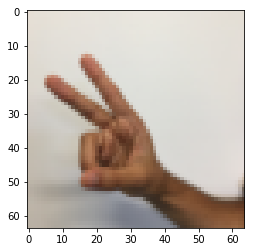

In [6]:
#visualizing data
index = 6
print("y = " + str(Y_train_orig[:,index]))
plt.imshow(X_train_orig[index])

In [7]:
# reshaping and normalizing train and test data 
# flatten the test and train X
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normaliz the test and train X
X_train_flatten = X_train_flatten/255
X_test_flatten = X_test_flatten/255

# on hot encode the labels
with tf.Session() as sess: 
    Y_train = one_hot_encoding(Y_train_orig, classes.shape[0], sess)
    Y_test = one_hot_encoding(Y_test_orig, classes.shape[0], sess)
print("Y train one hot =>" + str(Y_train.shape))
print("Y test one hot =>" + str(Y_test.shape))
print("X train: " + str(X_train_flatten.shape))
print("X test: " + str(X_test_flatten.shape))


n_x = X_train_flatten.shape[0]
n_y = Y_train.shape[0]

Y train one hot =>(6, 1080)
Y test one hot =>(6, 120)
X train: (12288, 1080)
X test: (12288, 120)


In [8]:
# model creation
# model -> (Linear-> ReLu) -> (Linear-> ReLu) -> (Linear-> Softmax)

tf.reset_default_graph()


#create placeholders
def create_placeholders(n_x, n_y):
    """
    Arguments:
    n_x - the size of input 
    n_y - the size of output
    
    Returns:
    X - a tensor with shape (n_x, None)
    Y - a tensor with shape (n_y, None)
    """
    X = tf.placeholder(tf.float32, shape=[n_x, None], name = 'X')
    Y = tf.placeholder(tf.float32, shape=[n_y, None], name = 'Y')
    
    return X, Y

tf.reset_default_graph()

#create parameter variables
def initialize_parameters(layers):
    """
    Arguments:
    layers - contains number of nodes in each hidden layer
    
    Returns:
    parameters = contains the weights and bias tensor for each layer
    """
    
    L = len(layers)
    n_prev = layers[0]
    parameters = {}
    
    tf.set_random_seed(1)
    
    for i in range(1, L):
        n = layers[i]
        W = tf.get_variable("W" + str(i), [n, n_prev], initializer=tf.contrib.layers.xavier_initializer(seed=1))
        b = tf.get_variable("b" + str(i), [n, 1], initializer=tf.contrib.layers.xavier_initializer(seed=1))
        parameters["W" + str(i)] = W
        parameters["b" + str(i)] = b
        n_prev = n
    
    return parameters

#print(initialize_parameters([12288, 25, 12, 6]))


tf.reset_default_graph()

#define the forward propagation i.e the computation graph
def forward_propagation(X, parameters):
    """
    Arguments:
    X - the input tensor
    parameters - the parameters for each layer in the model
    
    Returns:
    ZL - the Z of the last layer
    """
    
    L = int(len(parameters)/2)
    A_prev = X

    for l in range(1, L+1):
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        Z = tf.add(tf.matmul(W, A_prev), b)
        A = tf.nn.relu(Z)
        A_prev = A
        
    return Z
#X, Y = create_placeholders(12288, 6)
#print(forward_propagation(X, initialize_parameters([12288, 25, 12, 6])))



tf.reset_default_graph()

#compute cost
def compute_cost(ZL, Y):
    """
    Arguments:
    ZL - the Z of the last layer
    Y - the intended ouput
    
    Returns:
    cost - the tensor denoting the cost of the model
    """
    
    ZL = tf.transpose(ZL)
    Y = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ZL, labels = Y))
    
    return cost

#X, Y = create_placeholders(12288, 6)
#ZL = forward_propagation(X, initialize_parameters([12288, 25, 12, 6]))
#print(compute_cost(ZL, Y))


#put together everything into the model
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs=1500, mini_batch_size=32):
    """
    Arguments:
    X_train - training set
    Y_train - labels for training set
    X_test - test set
    Y_test - labels for test set
    learning_rate - the learning rate for gradient descent(default = 0.0001) 
    num_epochs - the number of interrations for which the model will train(default = 1500)
    mini_batch_size - the batch size for each mini batch(default = 32)
    
    Returns:
    
    """
    
    #to reset the graph each time we run
    tf.reset_default_graph()
    
    #initialize the seed to keep the result concistent
    seed=1
    tf.set_random_seed(1)
    
    #initialize basic variables
    n_x, m = X_train.shape
    n_y = Y_train.shape[0]
    costs = []                                       #to keep track of the costs at certain iterrations
    
    
    
    ##------------Creating the tensorlfow computation graph------------------------
    #create the placeholders
    X, Y = create_placeholders(n_x, n_y)
    
    #initialize the parameters
    layers = [12288, 25, 12, 6]
    parameters = initialize_parameters(layers)
    
    #forward propagate
    Z3 = forward_propagation(X, parameters)
    
    #initialize the cost
    cost = compute_cost(Z3, Y)
    
    #define the optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #initialize the global variables
    init = tf.global_variables_initializer()
    
    
    ##-------------------------running the model--------------------------------------
    with tf.Session() as sess:
        
        #run the inititalizer
        sess.run(init)
        
        #Train the model iterrating over epocs
        for epoch in range(num_epochs):
            
            #basic vairable initialization for each epoch
            epoch_cost = 0
            num_mini_batches = int(m / mini_batch_size)
            #generate the mini batch
            mini_batches = generate_random_mini_batch(X_train, Y_train, mini_batch_size, seed)
            seedd = seed + 1
            
            
            #iterrate over the mini batchs
            for batch in mini_batches:
                
                #get the x and y for the mini batch
                (X_mini, Y_mini) = batch
                
                #run the model on the mini batch
                _ , mini_batch_cost = sess.run([optimizer, cost], feed_dict={X : X_mini, Y: Y_mini})
                
                epoch_cost += mini_batch_cost
            
            #track the cost if needed
            if epoch % 5 == 0:
                epoch_cost /= num_mini_batches
                costs.append(epoch_cost)
                if epoch % 100 == 0:
                    print("cost after %i epochs is %f" % (epoch, epoch_cost))
    
        #plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
        
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print("Train accuracy:", accuracy.eval({X:X_train, Y:Y_train}))
        print("Train accuracy:", accuracy.eval({X:X_test, Y:Y_test}))
    
    

cost after %i epochs is %f (0, 1.9094127850099043)
cost after %i epochs is %f (100, 1.6677109978415749)
cost after %i epochs is %f (200, 1.5433038328633164)
cost after %i epochs is %f (300, 1.4522272348403931)
cost after %i epochs is %f (400, 1.3728655757326069)
cost after %i epochs is %f (500, 1.3131222435922334)
cost after %i epochs is %f (600, 1.2599869713638767)
cost after %i epochs is %f (700, 1.2101503538362908)
cost after %i epochs is %f (800, 1.1617241953358506)
cost after %i epochs is %f (900, 1.1137885451316833)
cost after %i epochs is %f (1000, 1.0659050598289028)
cost after %i epochs is %f (1100, 1.0178612199696628)
cost after %i epochs is %f (1200, 0.97048935565081507)
cost after %i epochs is %f (1300, 0.92370452302874939)
cost after %i epochs is %f (1400, 0.8785799001202439)


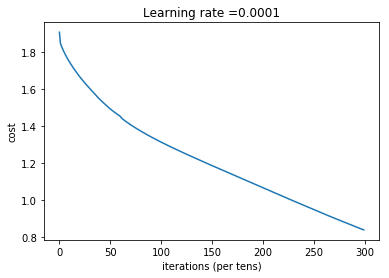

Train accuracy: 0.775
Train accuracy: 0.75


In [9]:
model(X_train_flatten, Y_train, X_test_flatten, Y_test)